In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../../src/')

%load_ext autoreload
%autoreload 2

%pdb

<IPython.core.display.Javascript object>

Automatic pdb calling has been turned ON


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import model_archs

from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot, plot_data
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2, sws_prune_copy
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
from retrain_layer import init_retrain_layer
from retrain_model import retrain_model

test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda/envs/py35/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### 1. Training Loss / Accuracy w/ Free Parameter Plots

In [4]:
model_kd_s, gmp_kd_s, res_kd_s = retrain_model(100, 10, 2500, 1250, 1e-6, int(0), 15, "LeNet_300_100", "full", 'CESNT', False, "./files")

0-component Mean: 1000.0 Variance: 10.0
Non-zero component Mean: 100.0 Variance: 2.0
Epoch: 10. Test Accuracy: 98.15
Epoch: 20. Test Accuracy: 98.03
Epoch: 30. Test Accuracy: 98.04
Epoch: 40. Test Accuracy: 98.07
Epoch: 50. Test Accuracy: 97.97
Retrain Test: 97.97, Prune Test: 75.18, Prune Sparsity: 98.09


96.54251528449795


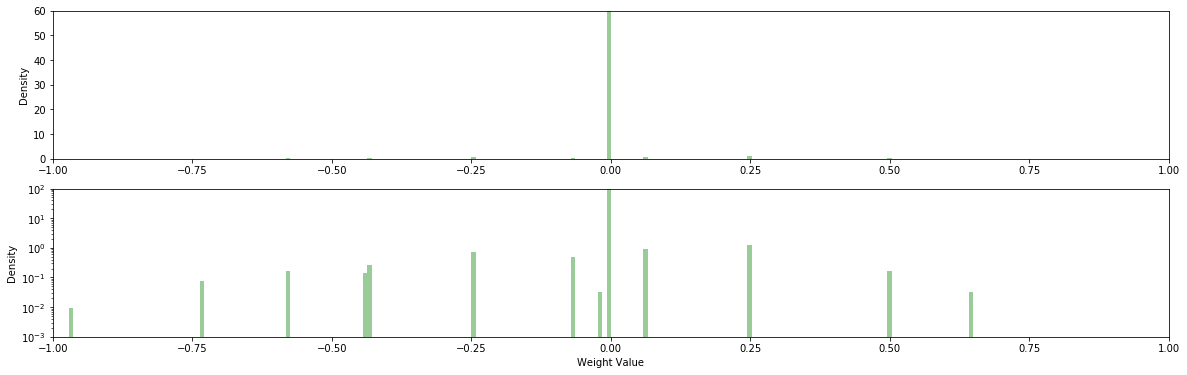

(97.68, 0.08251509070396423)

In [6]:
nm = sws_prune_copy(model_kd_s, gmp_kd_s)
print(get_sparsity(nm))
show_sws_weights(nm)
test_accuracy(test_data_full, test_labels_full, nm)

In [5]:
model_kd_s, gmp_kd_s, res_kd_s = retrain_model(1000, 10, 2500, 1250, 1e-6, int(0), 15, "LeNet_300_100", "full", 'CESNT', False, "")
model_kd_s, gmp_kd_s, res_kd_s = retrain_model(100, 10, 2500, 12, 1e-6, int(0), 15, "LeNet_300_100", "full", 'CESNT', False, "")

0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 1000.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.05
Epoch: 20. Test Accuracy: 97.30
Epoch: 30. Test Accuracy: 97.38
Epoch: 40. Test Accuracy: 97.48
Epoch: 50. Test Accuracy: 97.52
Retrain Test: 97.52, Prune Test: 96.19, Prune Sparsity: 97.42
0-component Mean: 2500.0 Variance: 12.0
Non-zero component Mean: 100.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.06
Epoch: 20. Test Accuracy: 98.03
Epoch: 30. Test Accuracy: 98.18
Epoch: 40. Test Accuracy: 98.19
Epoch: 50. Test Accuracy: 98.20
Retrain Test: 98.20, Prune Test: 94.08, Prune Sparsity: 96.80


### 2. Variance on Gamma Priors

In [5]:
vlist = [0.1, 1, 10, 100, 1000]
start_processing = False
#start from 10, 1000
for var in vlist:
    for zvar in [10000]:
        fn_text = "_var_{}_zvar_{}".format(var,zvar)
        model, gmp, res = retrain_model(100, var, 2500, zvar, 1e-6, int(0), 15, "LeNet_300_100", "full", 'CESNT', False, "./files", fn = fn_text)

0-component Mean: 2500.0 Variance: 10000.0
Non-zero component Mean: 100.0 Variance: 0.1
Epoch: 10. Test Accuracy: 97.26
Epoch: 20. Test Accuracy: 97.79
Epoch: 30. Test Accuracy: 98.04
Epoch: 40. Test Accuracy: 98.09
Epoch: 50. Test Accuracy: 98.15
Retrain Test: 98.15, Prune Test: 97.62, Prune Sparsity: 96.20
0-component Mean: 2500.0 Variance: 10000.0
Non-zero component Mean: 100.0 Variance: 1.0
Epoch: 10. Test Accuracy: 97.29
Epoch: 20. Test Accuracy: 97.88
Epoch: 30. Test Accuracy: 98.01
Epoch: 40. Test Accuracy: 98.07
Epoch: 50. Test Accuracy: 98.10
Retrain Test: 98.10, Prune Test: 97.43, Prune Sparsity: 96.10
0-component Mean: 2500.0 Variance: 10000.0
Non-zero component Mean: 100.0 Variance: 10.0
Epoch: 10. Test Accuracy: 97.26
Epoch: 20. Test Accuracy: 97.77
Epoch: 30. Test Accuracy: 97.98
Epoch: 40. Test Accuracy: 98.13
Epoch: 50. Test Accuracy: 98.21
Retrain Test: 98.21, Prune Test: 97.77, Prune Sparsity: 96.04
0-component Mean: 2500.0 Variance: 10000.0
Non-zero component Mean: 1

### 3. Means 

In [6]:
mlist = [0.1, 1, 10, 100, 1000, 10000]
#mean 0.1, zm = 10000
start_processing = False
stop_processing = False
for mean in mlist:
    for zmean in mlist:
        if (mean == 10000 and zmean == 0.1):
            stop_processing = True
        if (zmean == 10000 and mean ==0.1):
            start_processing = True
        if (start_processing and not stop_processing):
            model, gmp, res = retrain_model(mean, 0.1, zmean, 1000, 1e-6, int(0), 16, "LeNet_300_100", "full", 'CESNT', False, "./files")

0-component Mean: 10000.0 Variance: 1000.0
Non-zero component Mean: 0.1 Variance: 0.1
Epoch: 10. Test Accuracy: 97.69
Epoch: 20. Test Accuracy: 97.89
Epoch: 30. Test Accuracy: 98.13
Epoch: 40. Test Accuracy: 98.17
Epoch: 50. Test Accuracy: 98.17
Retrain Test: 98.17, Prune Test: 97.96, Prune Sparsity: 95.95
0-component Mean: 0.1 Variance: 1000.0000000000001
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 97.41
Epoch: 20. Test Accuracy: 97.94
Epoch: 30. Test Accuracy: 98.02
Epoch: 40. Test Accuracy: 98.12
Epoch: 50. Test Accuracy: 98.19
Retrain Test: 98.19, Prune Test: 97.77, Prune Sparsity: 95.90
0-component Mean: 1.0 Variance: 1000.0000000000001
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 97.44
Epoch: 20. Test Accuracy: 97.92
Epoch: 30. Test Accuracy: 98.06
Epoch: 40. Test Accuracy: 98.16
Epoch: 50. Test Accuracy: 98.19
Retrain Test: 98.19, Prune Test: 97.83, Prune Sparsity: 95.90
0-component Mean: 10.0 Variance: 1000.0
Non-zero component M

In [11]:
model, gmp, res = retrain_model(10000, 0.1, 1000, 1000, 1e-6, int(0), 16, "LeNet_300_100", "full", 'CESNT', False, "./files")

0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 10000.0 Variance: 0.1
Epoch: 10. Test Accuracy: 97.37
Epoch: 20. Test Accuracy: 95.54
Epoch: 30. Test Accuracy: 95.28
Epoch: 40. Test Accuracy: 95.31
Epoch: 50. Test Accuracy: 95.20
Retrain Test: 95.20, Prune Test: 76.10, Prune Sparsity: 98.55


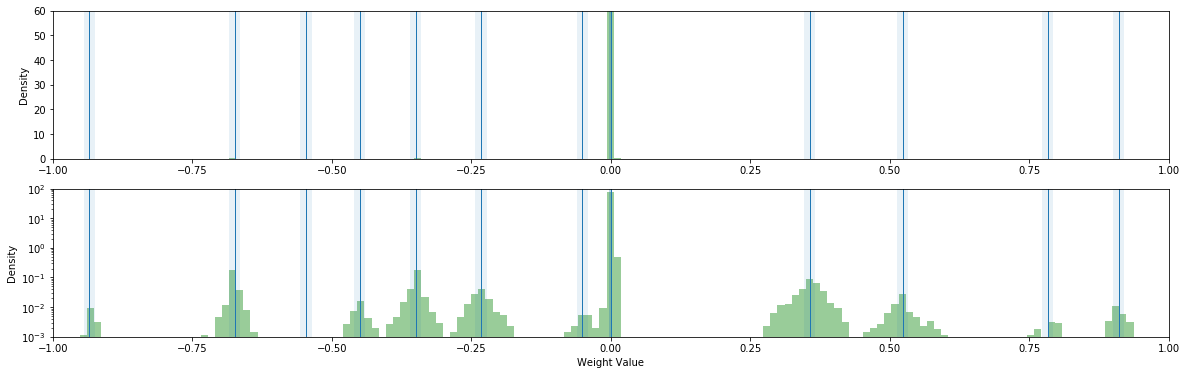

In [13]:
show_sws_weights(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))

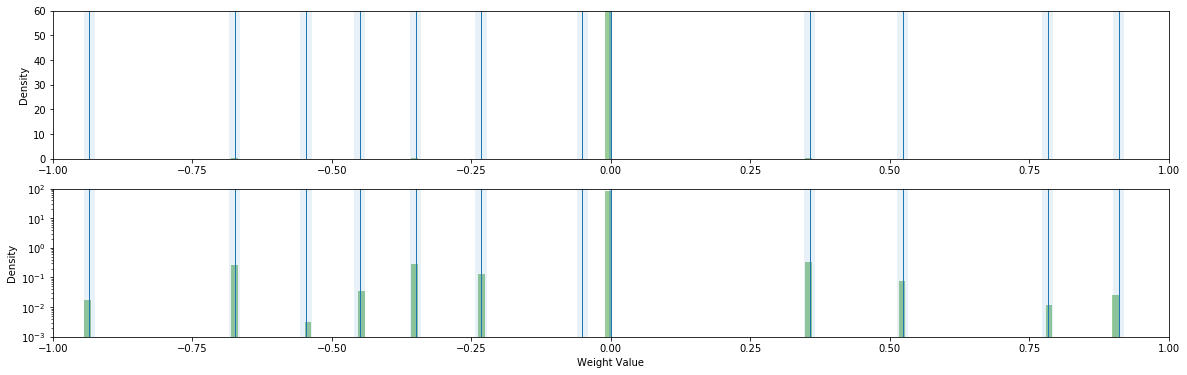

(76.08, 0.8191263675689697)

In [19]:
nm = sws_prune_copy(model, gmp)
show_sws_weights(model = nm, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()))
test_accuracy(test_data_full, test_labels_full, nm)

### 4. Mixtures

In [3]:
mixlist = [3, 6, 9, 12]#16
for mixtures in mixlist:
    model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 1e-6, int(0), mixtures, "LeNet_300_100", "full", 'CESNT', False, "./files")

0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 97.26
Epoch: 20. Test Accuracy: 97.84
Epoch: 30. Test Accuracy: 97.93
Epoch: 40. Test Accuracy: 98.14
Epoch: 50. Test Accuracy: 98.14
Retrain Test: 98.14, Prune Test: 9.80, Prune Sparsity: 100.00
0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 97.38
Epoch: 20. Test Accuracy: 97.86
Epoch: 30. Test Accuracy: 98.06
Epoch: 40. Test Accuracy: 98.11
Epoch: 50. Test Accuracy: 98.16
Retrain Test: 98.16, Prune Test: 25.99, Prune Sparsity: 98.95
0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 97.39
Epoch: 20. Test Accuracy: 97.82
Epoch: 30. Test Accuracy: 98.01
Epoch: 40. Test Accuracy: 98.16
Epoch: 50. Test Accuracy: 98.21
Retrain Test: 98.21, Prune Test: 93.21, Prune Sparsity: 97.59
0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance

### 5. Tau

In [4]:
taulist = [1e-4, 1e-5, 1e-7, 1e-8]#1e-6,
for tau in taulist:
    model, gmp, res = retrain_model(1, 0.1, 1000, 1000, tau, int(0), 16, "LeNet_300_100", "full", 'CESNT', False, "./files")

0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 38.76
Epoch: 20. Test Accuracy: 27.14
Epoch: 30. Test Accuracy: 31.53
Epoch: 40. Test Accuracy: 33.19
Epoch: 50. Test Accuracy: 35.05
Retrain Test: 35.05, Prune Test: 29.25, Prune Sparsity: 98.23
0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 92.43
Epoch: 20. Test Accuracy: 94.33
Epoch: 30. Test Accuracy: 95.08
Epoch: 40. Test Accuracy: 95.54
Epoch: 50. Test Accuracy: 95.82
Retrain Test: 95.82, Prune Test: 94.60, Prune Sparsity: 98.97
0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.36
Epoch: 20. Test Accuracy: 98.37
Epoch: 30. Test Accuracy: 98.13
Epoch: 40. Test Accuracy: 98.16
Epoch: 50. Test Accuracy: 98.20
Retrain Test: 98.20, Prune Test: 80.78, Prune Sparsity: 97.59
0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance

### 6. Final

In [ ]:
model, gmp, res = retrain_model(1, 0.1, 1000, 1000, 1e-6, int(0), 16, "SWSModel", "full", 'CESNT', False, "./files")

0-component Mean: 1000.0 Variance: 1000.0
Non-zero component Mean: 1.0 Variance: 0.1
Epoch: 10. Test Accuracy: 98.41
Epoch: 20. Test Accuracy: 98.81
